# **Importación de librerías a utilizar**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import regex
import emoji
import re
from collections import Counter
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# **Lectura de datos y generación de dataframe**

En primer lugar, creamos las funciones que servirán para extraer los datos a obtener de cada línea que se leerá del archivo txt donde se encuentra la conversación de WhatsApp. El detalle a continuación:
*   Fecha: Función obtener_fecha
*   Integrante: Función obtener_integrante
*   Texto: Función obtener_mensaje (pueden ser palabras, emojis, archivos, etc.)

In [2]:
def obtener_fecha(texto):
    if texto.startswith('['):
        fecha = texto.split(']')[0].split('[')[1] 
    else:
        fecha = np.NAN
    return fecha

def obtener_integrante(texto):
    if texto.startswith('['):
        integrante = texto.split(']')[1].strip().split(':')[0]   
    else:
        integrante = np.NAN
    return integrante  

def obtener_mensaje(texto):
    if texto.startswith('['):
        msj1 = texto.split(':')[3:]
        msj2 = ' '.join(msj1)  
        mensaje = msj2.strip().strip('\u200e')
    else:
        mensaje = texto.strip().strip('\u200e')
    return mensaje

Posteriormente, abrimos el archivo, leemos cada línea y aplicamos las funciones que hemos creado previamente para obtener las partes que nos interesan. Luego, almacenamos estos datos en un dataframe para proceder con la manipulación de datos.

In [3]:
ruta = "Chat wpp.txt" # Nombre con el cual se guardó la conversación exportada desde WhatsApp
lista = []

with open(ruta, encoding='utf-8') as file:
    file.readline() # Evitamos la primera línea por ser el mensaje predeterminado de encriptación al momento de iniciar la conversación de wpp
    
    while True: 
        linea = file.readline() # Leemos cada línea a partir de la segunda
        if not linea:
            break
        linea = linea.strip().strip('\u200e').strip('\n')
        fecha = obtener_fecha(linea)
        integrante = obtener_integrante(linea)
        mensaje = obtener_mensaje(linea)

        lista.append([fecha, integrante, mensaje])
        
df_wpp = pd.DataFrame(lista, columns=['Fecha', 'Integrante', 'Mensaje']) # Creamos el DataFrame a partir de la acumulación de listas en el anterior apartado
df_wpp.head() # Visualizamos las primeras 5 filas para obtener una visión general de cómo va quedando la información

,Fecha,Integrante,Mensaje
0,"8/15/19, 9:13:50 PM",Jairo M.,Quien te dijo ?
1,"8/15/19, 9:26:21 PM",Jairo M.,Aún no acepto v
2,"8/15/19, 9:34:07 PM",Rosario H.,Yo me entero de todo
3,"8/15/19, 9:34:08 PM",Rosario H.,😅
4,"8/15/19, 9:34:44 PM",Jairo M.,Dime quien te dijo


# **Exploración, limpieza y generación de variables**

En esta sección, identificamos la cantidad de valores nulos. Se observa que algunas filas no presentan la fecha ni el integrante. Esto se debe a que muchas veces se presiona la tecla 'enter' (en el celular) y esto ocasiona que haya un salto de línea en el mensaje y que no figure la fecha ni su remitente.

In [4]:
df_wpp.isna().sum() 

Fecha         36
Integrante    36
Mensaje        0
dtype: int64

Identificamos aquellas filas con valores vacíos en donde se aprecia que no hay datos en los campos fecha e integrante. 

In [5]:
vacios = df_wpp[df_wpp['Integrante'].isna()].index
df_wpp.loc[vacios].head()

,Fecha,Integrante,Mensaje
2961,NaN,NaN,Alcohol
3468,NaN,NaN,He bañanado
3764,NaN,NaN,Vamos ?
3821,NaN,NaN,Te que eres importante para mi 🥺
5737,NaN,NaN,Convalidó


Completamos los valores nulos con los valores inmediatos predecesores. Esto tiene sentido ya que estos mensajes sin remitente y fecha, que fueron causados por un salto de línea, corresponden a la misma persona que envió el mensaje anterior.

In [6]:
df_wpp = df_wpp.fillna(method = 'ffill', axis=0)
df_wpp.loc[vacios].head() # Corroboramos que estos valores (anteriormente vacíos) ya estén completos

,Fecha,Integrante,Mensaje
2961,"1/1/20, 9:27:28 AM",Jairo M.,Alcohol
3468,"1/21/20, 7:52:49 PM",Jairo M.,He bañanado
3764,"2/15/20, 3:47:56 AM",Jairo M.,Vamos ?
3821,"2/20/20, 4:13:26 PM",Jairo M.,Te que eres importante para mi 🥺
5737,"8/2/20, 10:31:05 AM",Jairo M.,Convalidó


Nuevamente definimos funciones para agregar 2 nuevos campos al dataframe. Una es para obtener los emojis que se incluyeron en un mensaje y la otra es para clasificar este mismo mensaje. A continuación el detalle:
*   Obtener los emojis de un mensaje (con la función obtener_emojis)
*   Clasificar los mensajes (identificar si se trata de un texto, link, sticker, imagen, video, audio, etc.) 

In [7]:
def obtener_emojis(mensaje):
    emojis_list = []
    caracteres = regex.findall(r'\X', mensaje)
    for caracter in caracteres:
        if caracter in emoji.EMOJI_DATA:
            emojis_list.append(caracter)
    return emojis_list

def clasificar_mensaje(mensaje):
    patron_url = r'https?\s?:?//\S+'
    buscar_url = re.findall(patron_url, mensaje)
    buscar_tipo = re.findall(r'omitted', mensaje)

    if len(buscar_url)>0:
        tipo = 'Link'
    elif len(buscar_tipo)>0:
        tipo = mensaje.strip().split()[-2].strip('\u200e').capitalize()
    else:
        tipo = 'Texto'
    return tipo

Con ayuda de las funciones definidas anteriormente, agregamos dichas columnas al dataframe : columna 'Emojis' y columna 'Tipo_mensaje'

In [8]:
df_wpp['Emojis'] = df_wpp['Mensaje'].apply(obtener_emojis)
df_wpp['Tipo_mensaje'] = df_wpp['Mensaje'].apply(clasificar_mensaje)
df_wpp.head()

,Fecha,Integrante,Mensaje,Emojis,Tipo_mensaje
0,"8/15/19, 9:13:50 PM",Jairo M.,Quien te dijo ?,[],Texto
1,"8/15/19, 9:26:21 PM",Jairo M.,Aún no acepto v,[],Texto
2,"8/15/19, 9:34:07 PM",Rosario H.,Yo me entero de todo,[],Texto
3,"8/15/19, 9:34:08 PM",Rosario H.,😅,[😅],Texto
4,"8/15/19, 9:34:44 PM",Jairo M.,Dime quien te dijo,[],Texto


# **Gráficos y estadísticas principales del chat de WhatsApp**

En este apartado, realizamos un ranking de los 10 emojis más utilizados en este chat. El más utilizado, por una gran diferencia (más que el doble de la segunda posición), fue el '😅'. Al parecer las risas nunca faltan cuando mi mejor amiga y yo chateamos por este medio. 

In [9]:
emojis_total = [a for b in df_wpp['Emojis'] for a in b]
emojis_dict = dict(Counter(emojis_total))
df_emojis = pd.DataFrame(emojis_dict.items(), columns = ['Emoji', 'Cantidad'])
df_emojis = df_emojis.sort_values('Cantidad', ascending=False).set_index('Emoji')
df_emojis.head(10)

,Cantidad
Emoji,
😅,754
🥺,369
🤣,304
🤔,154
🤗,135
👀,134
🙌🏻,96
😭,88
😂,66


Identificamos los tipos de mensajes que se encontraron mediante la clasficación (de acuerdo a la nueva columna 'Tipo_mensaje' creada en el dataframe).

In [10]:
df_wpp['Tipo_mensaje'].unique()

array(['Texto', 'Image', 'Sticker', 'Link', 'Audio', 'Document', 'Video'],
      dtype=object)

Tomando en cuenta lo anterior, generamos algunas estadísticas principales: cantidad de mensajes, cantidad de palabras por mensaje, cantidad de archivos multimedia, cantidad de links, cantidad de stickers y emojis. Luego almacenamos dichas estadísticas para cada integrante en un diccionario.

In [11]:
integrantes = df_wpp['Integrante'].unique()
dictionario = {}

for integrante in integrantes:
    
    msjs_integrante = df_wpp[df_wpp['Integrante']==integrante]

    cant_mensajes = msjs_integrante.shape[0]
    cant_palabras = round(np.sum(msjs_integrante['Mensaje'].apply(lambda x: len(x.split(' '))))/cant_mensajes,1)
    multimedia = msjs_integrante[msjs_integrante['Tipo_mensaje'].isin(('Video', 'Image', 'Audio'))].shape[0]
    link_doc = msjs_integrante[msjs_integrante['Tipo_mensaje'].isin(('Link', 'Document'))].shape[0]
    stickers = msjs_integrante[msjs_integrante['Tipo_mensaje']=='Sticker'].shape[0]
    emojis = np.sum(msjs_integrante['Emojis'].apply(len))

    lista = [cant_mensajes, cant_palabras, multimedia, link_doc, stickers, emojis]
    dictionario[integrante] = lista

dictionario # Visualizamos el resultado

{'Jairo M.': [8188, 3.6, 87, 17, 66, 1198],
 'Rosario H.': [7947, 3.3, 71, 27, 175, 1802]}

Acondicionamos este diccionario para almacernar los datos en un DataFrame y de esta forma facilitar la manipulación de dichos datos. Del resultado, se puede obervar que enviamos practicamente la misma cantidad de mensajes y que la mínima difirencia es compensada por la mayor cantidad de stickers y emojis que envía Rosario. Es evidente que ella, muchas veces, prefiere demostrar sus emociones mediante el uso de stickers y emojis.

In [12]:
df_estad = pd.DataFrame.from_dict(dictionario)
df_estad = df_estad.T
df_estad.columns = ['Cant_msjs', 'PalabrasxMsj', 'Cant_multimedia', 'Cant_links_doc', 'Cant_stickers', 'Cant_emojis']
df_estad

,Cant_msjs,PalabrasxMsj,Cant_multimedia,Cant_links_doc,Cant_stickers,Cant_emojis
Jairo M.,8188.0,3.6,87.0,17.0,66.0,1198.0
Rosario H.,7947.0,3.3,71.0,27.0,175.0,1802.0


En esta sección, agregamos 2 columnas que nos facilitarán la generación de gráficos analíticos: columnas 'Dia' y 'Hora'

In [13]:
df_wpp['Fecha'] = pd.to_datetime(df_wpp['Fecha'])
df_wpp['Dia'] = df_wpp['Fecha'].apply(lambda x: x.strftime('%A'))
df_wpp['Hora'] = df_wpp['Fecha'].apply(lambda x: str(x.hour)+'h-'+str(x.hour+1)+'h')
df_wpp.head()

,Fecha,Integrante,Mensaje,Emojis,Tipo_mensaje,Dia,Hora
0,2019-08-15 21:13:50,Jairo M.,Quien te dijo ?,[],Texto,Thursday,21h-22h
1,2019-08-15 21:26:21,Jairo M.,Aún no acepto v,[],Texto,Thursday,21h-22h
2,2019-08-15 21:34:07,Rosario H.,Yo me entero de todo,[],Texto,Thursday,21h-22h
3,2019-08-15 21:34:08,Rosario H.,😅,[😅],Texto,Thursday,21h-22h
4,2019-08-15 21:34:44,Jairo M.,Dime quien te dijo,[],Texto,Thursday,21h-22h


Generamos un gráfico de barras correspondiente a la cantidad de mensajes por día que se enviaron desde el 2019. Se observa que principalmente los mensajes aumentan los días jueves, viernes y sábado, lo que probablemente responde a 2 motivos: usualmente no nos vemos mucho los fines de semana y mantenemos más comunicación por este medio (WhatsApp) o porque chateamos con más frecuencia debido a que estamos quedando para algún evento o paseo.

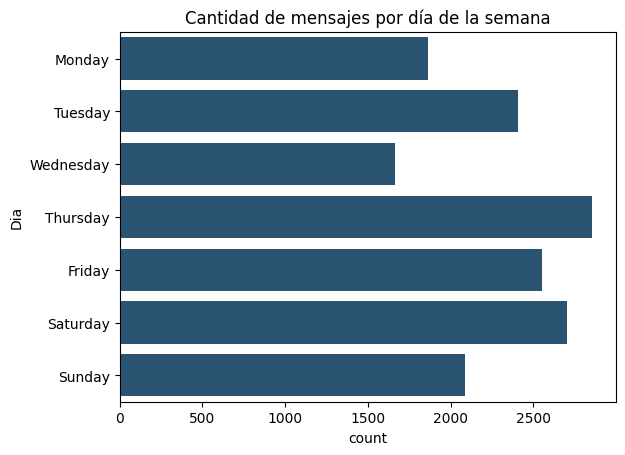

In [14]:
orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(y='Dia', data=df_wpp, order=orden, color='#1F547E')
plt.title('Cantidad de mensajes por día de la semana')
plt.show()

Generamos otro gráfico de barras correspondiente a la cantidad de mensajes por hora durante el día. Se observa que la mayor cantidad de mensajes se concentran entre las 9am y 1pm y entre las 7pm y 10pm. Esto obedece a que muchas veces hemos quedado para almorzar juntos (es por eso que la cantidad de mensajes aumentan durante estas horas), también solíamos escribirnos mucho durante la noche (especialmente al salir de clases 7pm-10pm) por si había oportunidad de juntarnos e ir a cenar o cualquier otro evento.

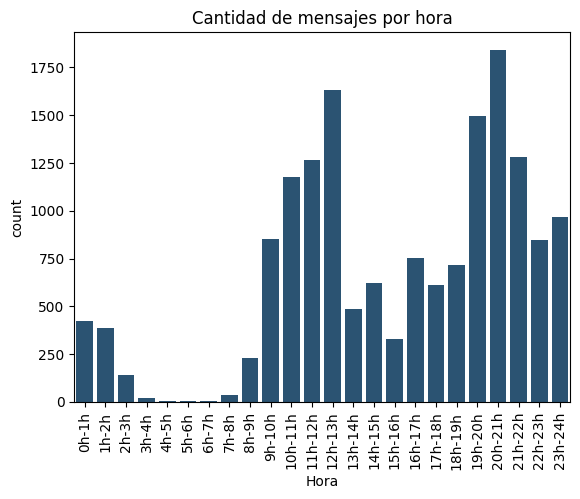

In [15]:
orden = ['0h-1h', '1h-2h', '2h-3h', '3h-4h', '4h-5h', '5h-6h', '6h-7h', '7h-8h', '8h-9h', '9h-10h', '10h-11h', '11h-12h', 
         '12h-13h', '13h-14h', '14h-15h', '15h-16h', '16h-17h', '17h-18h', '18h-19h', '19h-20h', '20h-21h', '21h-22h', '22h-23h', '23h-24h']
sns.countplot(x='Hora', data=df_wpp, order=orden, color='#1F547E')
plt.title('Cantidad de mensajes por hora')
plt.tick_params(axis='x', rotation=90)
plt.show()

# **Nube de palabras del chat de WhatsApp**

Finalmente, generamos una nube de palabras con el objetivo de identificar las palabras que más se utilizaron en la conversación de WhatsApp. Tal parece que las risas nunca faltaron en este chat. Es por eso que expresiones como 'jajaja' y 'xd' resaltan en el gráfico mostrado. También se observa mucho la forma en cómo nos referimos al otro: 'amiga', 'amigo'. Puede parecer un poco tradicional para los mejores amigos y varias personas pueden llamarse así (sin necesariamente tener una magnífica relación de amistad); sin embargo, esas dos palabras tienen un gran significado para mi y estoy seguro que también para ella.
Por otro lado, también se observa que siempre estamos interesados en ubicar al otro, por lo que palabras como 'donde', 'estas', 'estoy', etc. prevalecen en esta nube de palabras. 

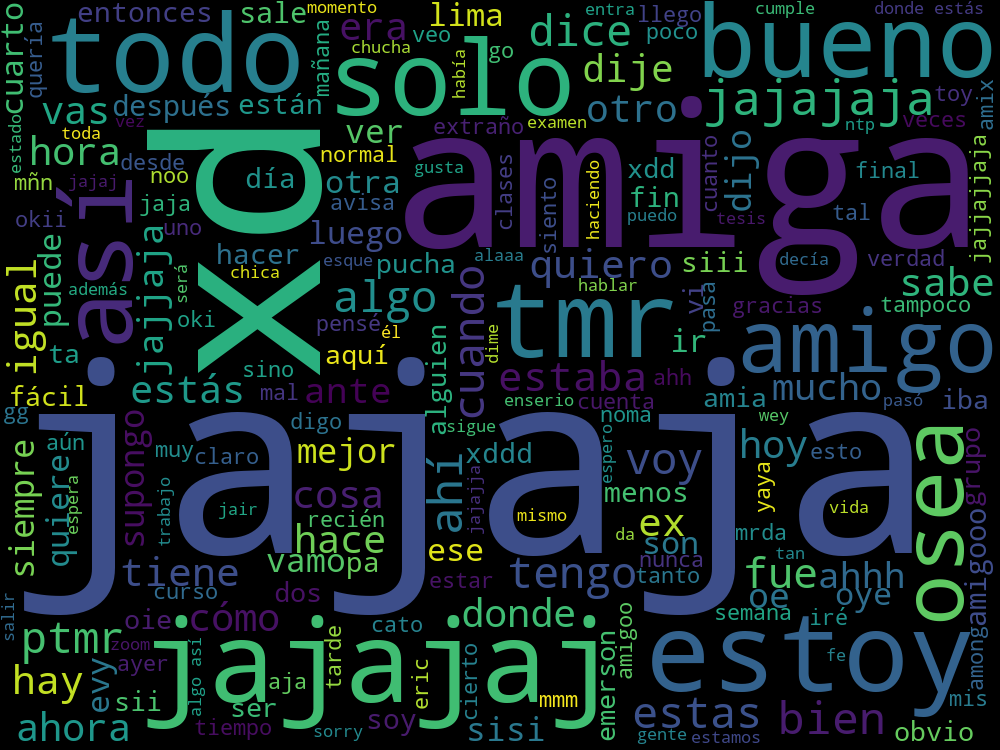

In [16]:
words_df = df_wpp[df_wpp['Tipo_mensaje']=='Texto']
grupo_palabras = ''

stopwords = STOPWORDS.update(['y', 'que', 'lo', 'te', 'de', 'se', 'el', 'si', 'p', 'e', 'v', 'por', 'pue', 'ya', 'la', 'pero', 'en', 'es', 'para', 'con', 'ps', 'las',
                              'ella', 'un', 'tu', 'tú', 'o', 'mi', 'creo', 'eso', 'le', 'una', 'yo', 'del', 'esta', 'porque', 'también', 'los', 'al', 'pues', 'su', 
                              'aunque', 'hasta', 'esa', 'sea', 'sin', 'qué', 'sé', 'quien', 'nos', 'si', 'ni', 'ah', 'ti', 'ma', 'sí', 'tus', 'como', 'nada', 'va', 
                              'más', 'mas', 'está', 'c'])

for mensaje in words_df['Mensaje'].values:
    palabras = str(mensaje).lower().split()
    for palabra in palabras:
        grupo_palabras = grupo_palabras + palabra + ' '

word_cloud = WordCloud(width=1000, height=750, 
                       background_color='black',
                       stopwords=stopwords,
                       min_font_size=10).generate(grupo_palabras)

word_cloud.to_image()